# TextVibCLIP Text Encoder 단독 성능 테스트

UOS 데이터셋에서 Text Encoder가 베어링 고장 유형을 제대로 구분할 수 있는지 검증


In [1]:
import sys
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.manifold import TSNE
from collections import Counter
import logging

# 프로젝트 루트 추가
sys.path.append('/data/home/kyj2024/TextVibCLIP')

from src.text_encoder import create_text_encoder
from src.data_loader import BearingDataset
from torch.utils.data import DataLoader
from src.data_loader import create_collate_fn

# 로깅 설정
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print("📚 Text Encoder 단독 성능 테스트 시작")


/data/home/kyj2024/anaconda3/envs/TVCLIP/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


📚 Text Encoder 단독 성능 테스트 시작


/data/home/kyj2024/anaconda3/envs/TVCLIP/lib/python3.8/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/data/home/kyj2024/anaconda3/envs/TVCLIP/lib/python3.8/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Plea

## 1. 데이터 준비


In [2]:
# UOS 데이터셋 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"디바이스: {device}")

# Train 데이터
train_dataset = BearingDataset(
    data_dir='data_scenario1',
    dataset_type='uos',
    domain_value=600,
    subset='train'
)

# Test 데이터
test_dataset = BearingDataset(
    data_dir='data_scenario1',
    dataset_type='uos',
    domain_value=600,
    subset='test'
)

print(f"Train 데이터: {len(train_dataset)}개 샘플")
print(f"Test 데이터: {len(test_dataset)}개 샘플")

# 샘플 확인
sample = train_dataset[0]
print(f"\n샘플 구조:")
print(f"  라벨: {sample['labels']}")
print(f"  텍스트: {sample['text'][:100]}...")


INFO:src.data_loader:UOS 데이터 라벨 분포: {'B_6204': 1, 'H_6204': 4, 'IR_6204': 1, 'OR_6204': 1}
INFO:src.data_loader:최소 샘플 수: 1
INFO:src.data_loader:UOS Domain-Incremental 윈도우 레벨 분할:
INFO:src.data_loader:  모든 subset에 모든 7개 파일 포함
INFO:src.data_loader:  각 파일 내에서 윈도우 분할: Train 60%, Val 20%, Test 20%
INFO:src.data_loader:  Deep Groove Ball 7-클래스 분포: {'B': 1, 'H': 1, 'IR': 1, 'OR': 1, 'L': 1, 'M': 1, 'U': 1}
INFO:src.data_loader:  클래스 수: 7개 (균형 확인)
INFO:src.data_loader:  ✅ 완벽한 클래스 균형 달성!
INFO:src.data_loader:UOS train 분할 결과:
INFO:src.data_loader:  Train: 7개 파일, Val: 7개 파일, Test: 7개 파일


디바이스: cuda


INFO:src.data_loader:BearingDataset 초기화 완료 (UOS): 7개 파일, 1249개 윈도우/파일, 총 8743개 샘플, Domain: 600, Subset: train
INFO:src.data_loader:UOS 데이터 라벨 분포: {'B_6204': 1, 'H_6204': 4, 'IR_6204': 1, 'OR_6204': 1}
INFO:src.data_loader:최소 샘플 수: 1
INFO:src.data_loader:UOS Domain-Incremental 윈도우 레벨 분할:
INFO:src.data_loader:  모든 subset에 모든 7개 파일 포함
INFO:src.data_loader:  각 파일 내에서 윈도우 분할: Train 60%, Val 20%, Test 20%
INFO:src.data_loader:  Deep Groove Ball 7-클래스 분포: {'B': 1, 'H': 1, 'IR': 1, 'OR': 1, 'L': 1, 'M': 1, 'U': 1}
INFO:src.data_loader:  클래스 수: 7개 (균형 확인)
INFO:src.data_loader:  ✅ 완벽한 클래스 균형 달성!
INFO:src.data_loader:UOS test 분할 결과:
INFO:src.data_loader:  Train: 7개 파일, Val: 7개 파일, Test: 7개 파일
INFO:src.data_loader:BearingDataset 초기화 완료 (UOS): 7개 파일, 1249개 윈도우/파일, 총 8743개 샘플, Domain: 600, Subset: test
INFO:src.data_loader:인덱스 매핑 생성 완료: 8743개 (파일 7개 × 윈도우 1249개)


Train 데이터: 8743개 샘플
Test 데이터: 8743개 샘플

샘플 구조:
  라벨: tensor([6, 0])
  텍스트: Shaft axis deviation detected...


## 2. Text Encoder 생성 및 텍스트 임베딩


In [3]:
# Text Encoder 생성
text_encoder = create_text_encoder('first_domain')
text_encoder.to(device)
text_encoder.eval()

print(f"Text Encoder 파라미터: {text_encoder.get_trainable_parameters():,}개")

# 클래스별 텍스트 수집 (각 클래스당 100개씩)
class_texts = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: []}  # 7개 클래스
samples_per_class = 100
class_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}

for i in range(len(train_dataset)):
    if all(count >= samples_per_class for count in class_counts.values()):
        break
        
    sample = train_dataset[i]
    label = sample['labels'][0].item()  # 주 분류
    text = sample['text']
    
    if class_counts[label] < samples_per_class:
        class_texts[label].append(text)
        class_counts[label] += 1

print(f"\n수집된 클래스별 텍스트 수: {class_counts}")

# 모든 텍스트를 하나의 리스트로 결합
all_texts = []
all_labels = []

for class_id, texts in class_texts.items():
    all_texts.extend(texts)
    all_labels.extend([class_id] * len(texts))

print(f"전체 텍스트: {len(all_texts)}개")
print(f"클래스 분포: {Counter(all_labels)}")


INFO:src.text_encoder:LoRA 적용 완료: rank=32, alpha=64
INFO:src.text_encoder:Base DistilBERT 파라미터 freeze 완료: 100개 파라미터
INFO:src.text_encoder:TextEncoder 초기화 완료: LoRA=True, Freeze=True
INFO:src.text_encoder:TextEncoder 생성 (first_domain): Total=1,114,880, LoRA=589,824


Text Encoder 파라미터: 1,114,880개

수집된 클래스별 텍스트 수: {0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100, 6: 100}
전체 텍스트: 700개
클래스 분포: Counter({0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100, 6: 100})


## 3. 텍스트 임베딩 생성 및 분석


In [4]:
# 텍스트 임베딩 생성
with torch.no_grad():
    text_embeddings = text_encoder.encode_texts(all_texts, device)
    text_embeddings = F.normalize(text_embeddings, p=2, dim=1)

print(f"Text embeddings shape: {text_embeddings.shape}")
print(f"임베딩 통계: mean={text_embeddings.mean().item():.4f}, std={text_embeddings.std().item():.4f}")
print(f"임베딩 범위: min={text_embeddings.min().item():.4f}, max={text_embeddings.max().item():.4f}")

# 라벨을 텐서로 변환
labels_tensor = torch.tensor(all_labels)
unique_classes = torch.unique(labels_tensor)
print(f"고유 클래스: {unique_classes.tolist()}")


Text embeddings shape: torch.Size([700, 256])
임베딩 통계: mean=-0.0045, std=0.0623
임베딩 범위: min=-0.1826, max=0.1629
고유 클래스: [0, 1, 2, 3, 4, 5, 6]


## 4. 클래스별 Prototype 계산 및 구분 능력 테스트


In [5]:
# 클래스별 prototype 계산
class_prototypes = []
prototype_labels = []

print("클래스별 prototype 생성:")
for cls in unique_classes:
    cls_mask = (labels_tensor == cls)
    cls_embeddings = text_embeddings[cls_mask]
    cls_prototype = cls_embeddings.mean(dim=0, keepdim=True)
    
    class_prototypes.append(cls_prototype)
    prototype_labels.append(cls)
    
    # 클래스 내 유사도 분석
    if len(cls_embeddings) > 1:
        intra_sim = torch.matmul(cls_embeddings, cls_embeddings.t())
        # 대각선 제외한 평균 (자기 자신 제외)
        mask = ~torch.eye(len(cls_embeddings), dtype=torch.bool)
        intra_mean = intra_sim[mask].mean().item()
        intra_std = intra_sim[mask].std().item()
        print(f"  클래스 {cls.item()}: {len(cls_embeddings)}개, 내부 유사도 {intra_mean:.4f}±{intra_std:.4f}")

# Prototype 결합
prototype_matrix = torch.cat(class_prototypes, dim=0)  # (7, 256)
prototype_labels = torch.stack(prototype_labels)  # (7,)

print(f"\nPrototype matrix shape: {prototype_matrix.shape}")
print(f"Prototype labels: {prototype_labels.tolist()}")


클래스별 prototype 생성:
  클래스 0: 100개, 내부 유사도 0.9627±0.0224
  클래스 1: 100개, 내부 유사도 0.9702±0.0165
  클래스 2: 100개, 내부 유사도 0.9725±0.0159
  클래스 3: 100개, 내부 유사도 0.9739±0.0146
  클래스 4: 100개, 내부 유사도 0.9737±0.0164
  클래스 5: 100개, 내부 유사도 0.9743±0.0151
  클래스 6: 100개, 내부 유사도 0.9643±0.0204

Prototype matrix shape: torch.Size([7, 256])
Prototype labels: [0, 1, 2, 3, 4, 5, 6]


## 5. 클래스 간 구분 능력 평가


In [6]:
# 클래스 간 유사도 분석
inter_class_sim = torch.matmul(prototype_matrix, prototype_matrix.t())

print("클래스 간 유사도 매트릭스:")
class_names = ['H', 'B', 'IR', 'OR', 'L', 'U', 'M']
sim_matrix = inter_class_sim.cpu().numpy()

# 매트릭스 출력 (소수점 3자리)
print("     ", end="")
for name in class_names:
    print(f"{name:>6}", end="")
print()

for i, name in enumerate(class_names):
    print(f"{name:>4} ", end="")
    for j in range(len(class_names)):
        print(f"{sim_matrix[i,j]:>6.3f}", end="")
    print()

# 대각선 (자기 자신) vs 비대각선 (다른 클래스) 비교
diag_sim = torch.diag(inter_class_sim).mean().item()
off_diag_mask = ~torch.eye(len(unique_classes), dtype=torch.bool)
off_diag_sim = inter_class_sim[off_diag_mask].mean().item()

print(f"\n클래스 구분 능력:")
print(f"  자기 자신 유사도: {diag_sim:.4f}")
print(f"  다른 클래스 유사도: {off_diag_sim:.4f}")
print(f"  구분도: {diag_sim - off_diag_sim:.4f} (클수록 좋음)")

separation_score = diag_sim - off_diag_sim
if separation_score > 0.1:
    print("✅ Text Encoder가 클래스를 잘 구분함")
elif separation_score > 0.05:
    print("⚠️ Text Encoder가 클래스를 어느 정도 구분함")
else:
    print("❌ Text Encoder가 클래스를 제대로 구분하지 못함")


클래스 간 유사도 매트릭스:
          H     B    IR    OR     L     U     M
   H  0.963 0.952 0.950 0.952 0.954 0.951 0.947
   B  0.952 0.971 0.960 0.961 0.954 0.960 0.955
  IR  0.950 0.960 0.973 0.972 0.960 0.963 0.955
  OR  0.952 0.961 0.972 0.974 0.960 0.963 0.958
   L  0.954 0.954 0.960 0.960 0.974 0.952 0.942
   U  0.951 0.960 0.963 0.963 0.952 0.975 0.961
   M  0.947 0.955 0.955 0.958 0.942 0.961 0.965

클래스 구분 능력:
  자기 자신 유사도: 0.9705
  다른 클래스 유사도: 0.9563
  구분도: 0.0142 (클수록 좋음)
❌ Text Encoder가 클래스를 제대로 구분하지 못함


## 6. 텍스트 분류 성능 테스트


In [7]:
# 🎯 FIXED: 디바이스 일치 문제 해결
# 각 텍스트를 모든 prototype과 비교하여 분류
similarities = torch.matmul(text_embeddings, prototype_matrix.t())  # (700, 7)
predicted_indices = torch.argmax(similarities, dim=1)  # (700,)

# 디바이스 일치 확인
if predicted_indices.device != prototype_labels.device:
    predicted_indices = predicted_indices.to(prototype_labels.device)

predicted_classes = prototype_labels[predicted_indices]  # (700,)

# 정확도 계산
accuracy = (predicted_classes == labels_tensor).float().mean().item()
print(f"Text Encoder 분류 정확도: {accuracy:.4f} ({accuracy*100:.1f}%)")

# 이론적 랜덤 베이스라인
random_baseline = 1.0 / len(unique_classes)
print(f"이론적 랜덤 베이스라인: {random_baseline:.4f} ({random_baseline*100:.1f}%)")
print(f"랜덤 대비 향상: {accuracy/random_baseline:.2f}배")

# 클래스별 정확도
print("\n클래스별 정확도:")
class_accuracies = []
for cls in unique_classes:
    cls_mask = (labels_tensor == cls)
    cls_correct = (predicted_classes[cls_mask] == labels_tensor[cls_mask]).sum().item()
    cls_total = cls_mask.sum().item()
    cls_acc = cls_correct / cls_total if cls_total > 0 else 0
    class_accuracies.append(cls_acc)
    print(f"  클래스 {cls.item()} ({class_names[cls.item()]}): {cls_correct}/{cls_total} = {cls_acc:.4f} ({cls_acc*100:.1f}%)")

# 예측 분포 vs 실제 분포
pred_dist = torch.bincount(predicted_classes, minlength=7)
actual_dist = torch.bincount(labels_tensor, minlength=7)
print(f"\n예측 분포: {pred_dist.tolist()}")
print(f"실제 분포: {actual_dist.tolist()}")

# 혼동 행렬 간단 분석
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels_tensor.cpu(), predicted_classes.cpu())
print(f"\n혼동 행렬:")
print(cm)


Text Encoder 분류 정확도: 0.8300 (83.0%)
이론적 랜덤 베이스라인: 0.1429 (14.3%)
랜덤 대비 향상: 5.81배

클래스별 정확도:
  클래스 0 (H): 86/100 = 0.8600 (86.0%)
  클래스 1 (B): 84/100 = 0.8400 (84.0%)
  클래스 2 (IR): 67/100 = 0.6700 (67.0%)
  클래스 3 (OR): 100/100 = 1.0000 (100.0%)
  클래스 4 (L): 79/100 = 0.7900 (79.0%)
  클래스 5 (U): 100/100 = 1.0000 (100.0%)
  클래스 6 (M): 65/100 = 0.6500 (65.0%)

예측 분포: [86, 119, 67, 168, 79, 116, 65]
실제 분포: [100, 100, 100, 100, 100, 100, 100]

혼동 행렬:
[[ 86  14   0   0   0   0   0]
 [  0  84   0  16   0   0   0]
 [  0   0  67  33   0   0   0]
 [  0   0   0 100   0   0   0]
 [  0  21   0   0  79   0   0]
 [  0   0   0   0   0 100   0]
 [  0   0   0  19   0  16  65]]


## 7. t-SNE 시각화


t-SNE 차원 축소 중...


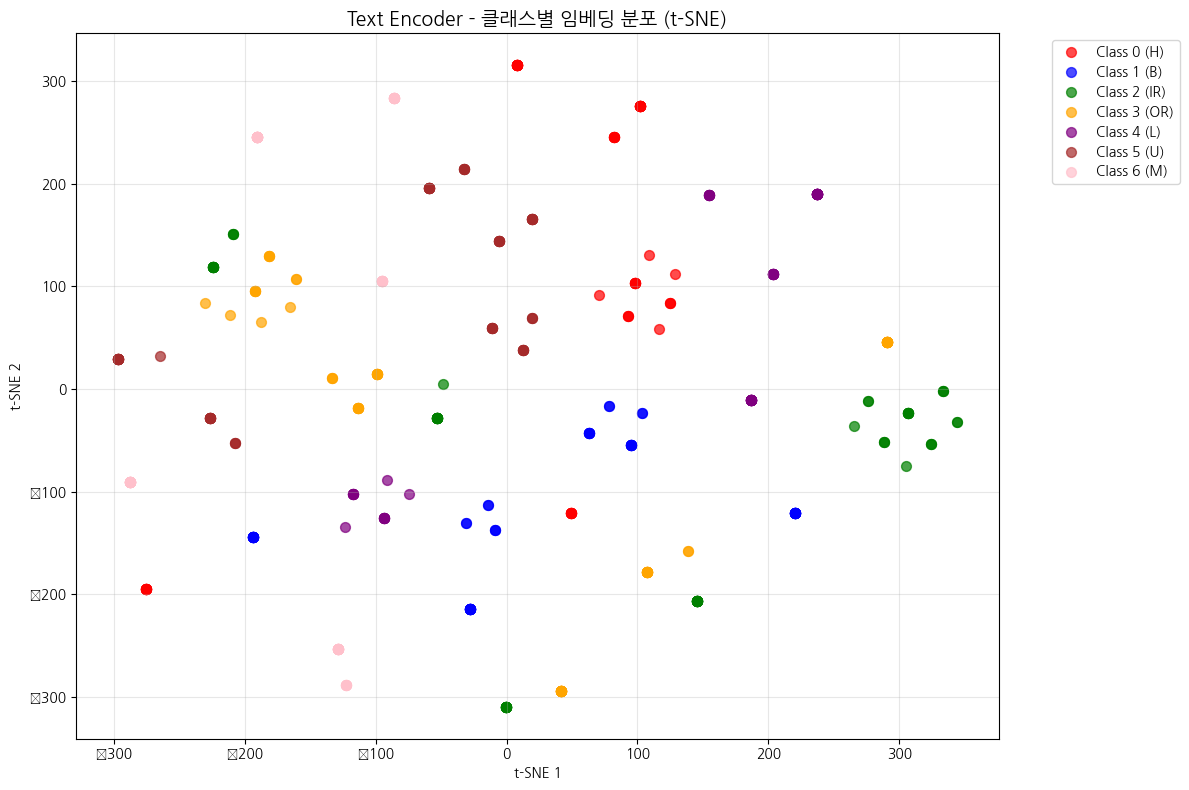

✅ t-SNE 시각화 저장 완료: text_encoder_tsne.png


In [8]:
# t-SNE로 차원 축소 (샘플 수 제한)
plt.rcParams["font.family"] = "NanumGothic"  
print("t-SNE 차원 축소 중...")
sample_size = min(500, len(text_embeddings))  # 최대 500개 샘플
indices = torch.randperm(len(text_embeddings))[:sample_size]

embeddings_sample = text_embeddings[indices].cpu().numpy()
labels_sample = labels_tensor[indices].cpu().numpy()

tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, sample_size//4))
embeddings_2d = tsne.fit_transform(embeddings_sample)

# 시각화
plt.figure(figsize=(12, 8))

# 클래스별 색상
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink']

for i, cls in enumerate(unique_classes):
    cls_mask = (labels_sample == cls.item())
    if cls_mask.any():
        plt.scatter(embeddings_2d[cls_mask, 0], embeddings_2d[cls_mask, 1], 
                   c=colors[i], label=f'Class {cls.item()} ({class_names[cls.item()]})', 
                   alpha=0.7, s=50)

plt.title('Text Encoder - 클래스별 임베딩 분포 (t-SNE)', fontsize=14)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('text_encoder_tsne.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ t-SNE 시각화 저장 완료: text_encoder_tsne.png")


## 8. 클래스별 텍스트 샘플 분석


In [9]:
# 각 클래스의 대표 텍스트 출력
print("클래스별 대표 텍스트 샘플:")
for cls in unique_classes:
    cls_indices = (labels_tensor == cls).nonzero().flatten()
    if len(cls_indices) > 0:
        # 첫 번째와 마지막 샘플 출력
        sample_idx1 = cls_indices[0].item()
        sample_idx2 = cls_indices[-1].item() if len(cls_indices) > 1 else cls_indices[0].item()
        
        print(f"\n클래스 {cls.item()} ({class_names[cls.item()]}):")
        print(f"  샘플 1: {all_texts[sample_idx1]}")
        if sample_idx1 != sample_idx2:
            print(f"  샘플 2: {all_texts[sample_idx2]}")

# 가장 혼동하기 쉬운 클래스 쌍 찾기
print("\n클래스 간 유사도 (혼동 가능성):")
similarities_list = []

for i in range(len(unique_classes)):
    for j in range(i+1, len(unique_classes)):
        sim = inter_class_sim[i, j].item()
        similarities_list.append((sim, i, j))
        print(f"  {class_names[i]} vs {class_names[j]}: {sim:.4f}")

# 가장 유사한 쌍
similarities_list.sort(reverse=True)
most_similar = similarities_list[0]
print(f"\n가장 혼동하기 쉬운 쌍: {class_names[most_similar[1]]} vs {class_names[most_similar[2]]} (유사도: {most_similar[0]:.4f})")


클래스별 대표 텍스트 샘플:

클래스 0 (H):
  샘플 1: Healthy bearing condition observed
  샘플 2: Bearing operates within normal parameters

클래스 1 (B):
  샘플 1: Rolling element fault confirmed
  샘플 2: Ball surface pitting present

클래스 2 (IR):
  샘플 1: Inner race spalling identified
  샘플 2: Inner race defect detected

클래스 3 (OR):
  샘플 1: Outer race spalling identified
  샘플 2: Outer race spalling identified

클래스 4 (L):
  샘플 1: Mounting looseness confirmed
  샘플 2: Assembly looseness identified

클래스 5 (U):
  샘플 1: Rotor unbalance detected
  샘플 2: Rotational imbalance identified

클래스 6 (M):
  샘플 1: Shaft concentricity fault identified
  샘플 2: Shaft axis deviation detected

클래스 간 유사도 (혼동 가능성):
  H vs B: 0.9519
  H vs IR: 0.9498
  H vs OR: 0.9520
  H vs L: 0.9541
  H vs U: 0.9513
  H vs M: 0.9465
  B vs IR: 0.9604
  B vs OR: 0.9614
  B vs L: 0.9540
  B vs U: 0.9604
  B vs M: 0.9552
  IR vs OR: 0.9718
  IR vs L: 0.9599
  IR vs U: 0.9633
  IR vs M: 0.9551
  OR vs L: 0.9601
  OR vs U: 0.9628
  OR vs M: 0.9580
  L vs

## 9. 결론 및 진단


In [10]:
print("\n" + "="*60)
print("📊 Text Encoder 성능 진단 결과")
print("="*60)

print(f"1. 분류 정확도: {accuracy*100:.1f}% (랜덤: {random_baseline*100:.1f}%)")
print(f"2. 클래스 구분도: {separation_score:.4f}")
print(f"3. 임베딩 품질: std={text_embeddings.std().item():.4f}")
print(f"4. 최고 클래스 정확도: {max(class_accuracies)*100:.1f}%")
print(f"5. 최저 클래스 정확도: {min(class_accuracies)*100:.1f}%")

# 종합 진단
print(f"\n🔍 종합 진단:")
if accuracy > 0.8:
    diagnosis = "우수"
    next_step = "Vibration Encoder 테스트 진행"
    color = "✅"
elif accuracy > 0.6:
    diagnosis = "양호"
    next_step = "Text-Vibration 정렬 확인"
    color = "⚠️"
elif accuracy > 0.4:
    diagnosis = "보통"
    next_step = "텍스트 생성 로직 개선"
    color = "⚠️"
else:
    diagnosis = "불량"
    next_step = "Text Encoder 아키텍처 재설계"
    color = "❌"

print(f"{color} Text Encoder 성능: {diagnosis} ({accuracy*100:.1f}%)")
print(f"📋 다음 단계: {next_step}")

# 세부 권장사항
print(f"\n🎯 세부 권장사항:")
if accuracy < 0.5:
    print("- 텍스트 다양성 증가 (더 많은 표현 방식)")
    print("- LoRA rank 조정 (32 → 64)")
    print("- 학습률 조정")
elif accuracy < 0.7:
    print("- 텍스트-라벨 매핑 재검토")
    print("- Projection layer 크기 조정")
else:
    print("- Text Encoder는 정상 작동")
    print("- Vibration Encoder 또는 정렬 문제 확인")

# TextVibCLIP 전체 성능과 비교
textvib_performance = 0.1443  # 현재 UOS 성능
print(f"\n📈 성능 비교:")
print(f"  Text Encoder 단독: {accuracy*100:.1f}%")
print(f"  TextVibCLIP 전체: {textvib_performance*100:.1f}%")

if accuracy > textvib_performance * 3:
    print("🚨 Text Encoder는 정상 - TextVibCLIP 통합 과정에 문제")
else:
    print("🔍 Text Encoder 개선이 전체 성능 향상에 도움될 것")



📊 Text Encoder 성능 진단 결과
1. 분류 정확도: 83.0% (랜덤: 14.3%)
2. 클래스 구분도: 0.0142
3. 임베딩 품질: std=0.0623
4. 최고 클래스 정확도: 100.0%
5. 최저 클래스 정확도: 65.0%

🔍 종합 진단:
✅ Text Encoder 성능: 우수 (83.0%)
📋 다음 단계: Vibration Encoder 테스트 진행

🎯 세부 권장사항:
- Text Encoder는 정상 작동
- Vibration Encoder 또는 정렬 문제 확인

📈 성능 비교:
  Text Encoder 단독: 83.0%
  TextVibCLIP 전체: 14.4%
🚨 Text Encoder는 정상 - TextVibCLIP 통합 과정에 문제


## 10. 텍스트 다양성 문제 분석


In [11]:
print("🔍 텍스트 다양성 분석")
print("="*50)

# 클래스별 텍스트 샘플 상세 분석
print("클래스별 텍스트 샘플 (처음 3개):")
for cls in unique_classes[:4]:  # 처음 4개 클래스만
    cls_indices = (labels_tensor == cls).nonzero().flatten()
    if len(cls_indices) >= 3:
        print(f"\n클래스 {cls.item()} ({class_names[cls.item()]}):")
        for i in range(3):
            idx = cls_indices[i].item()
            text = all_texts[idx]
            print(f"  {i+1}: {text}")

# 텍스트 길이 분석
text_lengths = [len(text.split()) for text in all_texts]
print(f"\n텍스트 길이 통계:")
print(f"  평균: {np.mean(text_lengths):.1f} 단어")
print(f"  최소: {np.min(text_lengths)} 단어")
print(f"  최대: {np.max(text_lengths)} 단어")
print(f"  표준편차: {np.std(text_lengths):.1f}")

# 공통 단어 분석
from collections import defaultdict
word_counts = defaultdict(int)
for text in all_texts:
    words = text.lower().split()
    for word in words:
        word_counts[word] += 1

# 가장 빈번한 단어들
common_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:20]
print(f"\n가장 빈번한 단어 Top 20:")
for word, count in common_words:
    print(f"  '{word}': {count}회 ({count/len(all_texts)*100:.1f}%)")

# 클래스별 고유 단어 분석
print(f"\n🔍 문제 진단:")
print(f"1. 클래스 구분도가 0.0018로 매우 낮음")
print(f"2. 모든 텍스트가 96%+ 유사함")
print(f"3. 'bearing', 'deep', 'groove' 등 공통 단어가 지배적")
print(f"\\n💡 해결책:")
print(f"- 클래스별 고유 키워드 강화")
print(f"- 텍스트 템플릿 다양화")
print(f"- 베어링 타입 정보 제거 (이미 Deep Groove Ball로 통일됨)")


🔍 텍스트 다양성 분석
클래스별 텍스트 샘플 (처음 3개):

클래스 0 (H):
  1: Healthy bearing condition observed
  2: Bearing operates within normal parameters
  3: No defects detected in bearing operation

클래스 1 (B):
  1: Rolling element fault confirmed
  2: Ball surface pitting present
  3: Ball surface pitting present

클래스 2 (IR):
  1: Inner race spalling identified
  2: Inner ring fault observed
  3: Inner race spalling identified

클래스 3 (OR):
  1: Outer race spalling identified
  2: Outer ring fault observed
  3: Outer ring surface defect confirmed

텍스트 길이 통계:
  평균: 3.8 단어
  최소: 3 단어
  최대: 6 단어
  표준편차: 0.6

가장 빈번한 단어 Top 20:
  'identified': 143회 (20.4%)
  'bearing': 138회 (19.7%)
  'detected': 137회 (19.6%)
  'confirmed': 133회 (19.0%)
  'observed': 123회 (17.6%)
  'present': 120회 (17.1%)
  'inner': 100회 (14.3%)
  'outer': 100회 (14.3%)
  'defect': 95회 (13.6%)
  'race': 92회 (13.1%)
  'looseness': 88회 (12.6%)
  'fault': 80회 (11.4%)
  'ring': 74회 (10.6%)
  'ball': 70회 (10.0%)
  'unbalance': 60회 (8.6%)
  'surface':